## [Ссылка на датасет](https://huggingface.co/datasets/Rianknow/creditscoring)


In [1]:
import shap
import pickle
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold

/Users/admin/Dev/vue/sibsutis/CRM-SibSUTIS/backend/model/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./dataset/creditscoring/train.csv', sep = ',')
df.replace('_', np.nan, inplace = True)
df.head()

/var/folders/_m/n57jfftj32jbkm7dyvz9gpj80000gn/T/ipykernel_52313/3777082345.py:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./dataset/creditscoring/train.csv', sep = ',')


,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,NaN,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [3]:
df.dtypes 

ID                           object
Customer_ID                  object
Month                        object
Name                         object
Age                          object
SSN                          object
Occupation                   object
Annual_Income                object
Monthly_Inhand_Salary       float64
Num_Bank_Accounts             int64
Num_Credit_Card               int64
Interest_Rate                 int64
Num_of_Loan                  object
Type_of_Loan                 object
Delay_from_due_date           int64
Num_of_Delayed_Payment       object
Changed_Credit_Limit         object
Num_Credit_Inquiries        float64
Credit_Mix                   object
Outstanding_Debt             object
Credit_Utilization_Ratio    float64
Credit_History_Age           object
Payment_of_Min_Amount        object
Total_EMI_per_month         float64
Amount_invested_monthly      object
Payment_Behaviour            object
Monthly_Balance              object
Credit_Score                

In [4]:
df.shape

# df.drop(columns='Name', inplace=True, axis=1) # Удаление столбца

(100000, 28)

In [5]:
print((df.isnull().sum())/df.shape[0]*100)


ID                           0.000
Customer_ID                  0.000
Month                        0.000
Name                         9.985
Age                          0.000
SSN                          0.000
Occupation                   0.000
Annual_Income                0.000
Monthly_Inhand_Salary       15.002
Num_Bank_Accounts            0.000
Num_Credit_Card              0.000
Interest_Rate                0.000
Num_of_Loan                  0.000
Type_of_Loan                11.408
Delay_from_due_date          0.000
Num_of_Delayed_Payment       7.002
Changed_Credit_Limit         2.091
Num_Credit_Inquiries         1.965
Credit_Mix                  20.195
Outstanding_Debt             0.000
Credit_Utilization_Ratio     0.000
Credit_History_Age           9.030
Payment_of_Min_Amount        0.000
Total_EMI_per_month          0.000
Amount_invested_monthly      4.479
Payment_Behaviour            0.000
Monthly_Balance              1.200
Credit_Score                 0.000
dtype: float64


In [6]:
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace('_', '')
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].str.replace('__', '')
df['Monthly_Balance'] = df['Monthly_Balance'].str.replace('__', '')
df['Age'] = df['Age'].str.replace('_', '')
df['Annual_Income'] = df['Annual_Income'].str.replace('_', '')
df['Outstanding_Debt'] = df['Outstanding_Debt'].str.replace('_', '')
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace('_', '')
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].str.replace('_', '')

df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].astype(float)
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].astype(float)
df['Monthly_Balance'] = df['Monthly_Balance'].astype(float)
df['Age'] = df['Age'].astype(int)
df['Annual_Income'] = df['Annual_Income'].astype(float)
df['Outstanding_Debt'] = df['Outstanding_Debt'].astype(float)
df['Num_of_Loan'] = df['Num_of_Loan'].astype(float)
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].astype(float)

In [7]:
dropCol = [
    'ID', 
    'SSN', 
    'Name', 
    'Customer_ID', 
    'Num_Credit_Inquiries', # Номер платежа 
    'Num_of_Delayed_Payment', # Номер платежа 
    'Num_of_Loan', # Номер кредита 
    # 'Credit_History_Age', 
    'Outstanding_Debt', 
    'Changed_Credit_Limit', 
    'Credit_Utilization_Ratio', # Процент погашенного кредита
    'Num_Credit_Card', 
    'Payment_of_Min_Amount',
    'Monthly_Balance', 
    'Amount_invested_monthly',
    
    'Delay_from_due_date', 
    'Num_Bank_Accounts', 
    'Month'
]

# TODO: сделать рассчет Total_EMI_per_month, Amount_invested_monthly

# df.drop(['Credit_Utilization_Ratio', 'Amount_invested_monthly', 'Monthly_Inhand_Salary'], inplace=True, axis=1)
# df.drop(['Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Num_of_Loan', 'Annual_Income'], inplace=True, axis=1)
# df.drop(['Total_EMI_per_month', 'Monthly_Balance'], inplace=True, axis=1)

for col in dropCol:
  df.drop(columns=col, inplace=True, axis=1)

cat_features = []

for col_name, col_type in df.dtypes.items():
  if (col_type == object):
    cat_features.append(col_name)

del cat_features[cat_features.index('Credit_Score')]

df = df[df['Age'] > 0]

cat_features


['Occupation',
 'Type_of_Loan',
 'Credit_Mix',
 'Credit_History_Age',
 'Payment_Behaviour']

In [8]:
def for_cat_Nan(df, features):
    for feature in features:
        mode_value = df[feature].mode()[0]
        df[feature].fillna(mode_value, inplace=True)
def for_num_Nan(df, features):
    for feature in features:
        median_value = df[feature].mode()[0]
        df[feature].fillna(median_value, inplace=True)

cat_Nan = ['Type_of_Loan', 'Credit_Mix']
num_Nan = ['Monthly_Inhand_Salary']

for_cat_Nan(df,cat_Nan)
for_num_Nan(df,num_Nan)

/var/folders/_m/n57jfftj32jbkm7dyvz9gpj80000gn/T/ipykernel_52313/1718618366.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(mode_value, inplace=True)
/var/folders/_m/n57jfftj32jbkm7dyvz9gpj80000gn/T/ipykernel_52313/1718618366.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [9]:
print((df.isnull().sum())/df.shape[0]*100)

Age                      0.000000
Occupation               0.000000
Annual_Income            0.000000
Monthly_Inhand_Salary    0.000000
Interest_Rate            0.000000
Type_of_Loan             0.000000
Credit_Mix               0.000000
Credit_History_Age       9.034042
Total_EMI_per_month      0.000000
Payment_Behaviour        0.000000
Credit_Score             0.000000
dtype: float64


In [10]:
df.dtypes

Age                        int64
Occupation                object
Annual_Income            float64
Monthly_Inhand_Salary    float64
Interest_Rate              int64
Type_of_Loan              object
Credit_Mix                object
Credit_History_Age        object
Total_EMI_per_month      float64
Payment_Behaviour         object
Credit_Score              object
dtype: object

In [11]:
label_encoder = LabelEncoder()

for col_name, col_type in df.dtypes.items():
  if (col_type == object):
    print(df[col_name].value_counts(), end='\n\n')
    df[col_name] = label_encoder.fit_transform(df[col_name])

Occupation
_______          7001
Lawyer           6505
Architect        6303
Engineer         6295
Scientist        6238
Mechanic         6229
Accountant       6221
Media_Manager    6176
Developer        6169
Teacher          6153
Entrepreneur     6134
Journalist       6036
Doctor           6025
Manager          5932
Musician         5857
Writer           5840
Name: count, dtype: int64

Type_of_Loan
Not Specified                                                                                                                         12699
Credit-Builder Loan                                                                                                                    1271
Personal Loan                                                                                                                          1263
Debt Consolidation Loan                                                                                                                1246
Student Loan                         

In [12]:
df.rename(columns={'Credit_Score': 'target'}, inplace=True)

In [13]:
df.head()

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Interest_Rate,Type_of_Loan,Credit_Mix,Credit_History_Age,Total_EMI_per_month,Payment_Behaviour,target
0,23,12,19114.12,1824.843333,3,128,2,180,49.574949,3,0
1,23,12,19114.12,2295.058333,3,128,1,404,49.574949,4,0
3,23,12,19114.12,2295.058333,3,128,1,185,49.574949,6,0
4,23,12,19114.12,1824.843333,3,128,1,186,49.574949,2,0
5,23,12,19114.12,2295.058333,3,128,1,187,49.574949,0,0



---
## Валидация


In [14]:
df

,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Interest_Rate,Type_of_Loan,Credit_Mix,Credit_History_Age,Total_EMI_per_month,Payment_Behaviour,target
0,23,12,19114.12,1824.843333,3,128,2,180,49.574949,3,0
1,23,12,19114.12,2295.058333,3,128,1,404,49.574949,4,0
3,23,12,19114.12,2295.058333,3,128,1,185,49.574949,6,0
4,23,12,19114.12,1824.843333,3,128,1,186,49.574949,2,0
5,23,12,19114.12,2295.058333,3,128,1,187,49.574949,0,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,25,9,39628.99,3359.415833,7,683,2,307,35.104023,1,1
99996,25,9,39628.99,3359.415833,7,683,2,308,35.104023,2,1
99997,25,9,39628.99,3359.415833,5729,683,1,309,35.104023,1,1
99998,25,9,39628.99,3359.415833,7,683,1,310,35.104023,4,2


In [ ]:


# Предполагаем, что df_for_auto уже определен и содержит три класса в столбце 'target'
X = df.drop(['target'], axis=1)
y = df['target']
n_splits = 10

clfs = []
scores = []
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7575)

class_weights = {
    'Poor': 1.5, 
    'Standard': 1.0, 
    'Good': 2.0
}

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Разделение обучающего набора на обучающую и валидационную выборки
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=7575)

    # Создайте CatBoostClassifier для многоклассовой классификации
    clf_for_catboost = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        cat_features=cat_features,
        eval_metric='MultiClass',  # Установите метрику для многоклассовой классификации
        random_seed=7575,
        verbose=0,  # Установите в 0, чтобы отключить вывод во время обучения
        # class_weights=class_weights
    )

    clfs.append(clf_for_catboost)

    # Обучение модели на обучающей выборке
    clf_for_catboost.fit(X_train, y_train)

    # Прогнозирование на тестовом наборе
    y_pred = clf_for_catboost.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)
    
    print(f"fold: acc: {score}")

assert len(clfs) == n_splits
print("mean accuracy score --", np.mean(scores), np.std(scores).round(4))

fold: acc: 0.766545601291364
fold: acc: 0.7694713478611783
fold: acc: 0.766545601291364
fold: acc: 0.7672518159806295
fold: acc: 0.7661184542427606
fold: acc: 0.7723741297548179
fold: acc: 0.7695489859751791
fold: acc: 0.7712642518413884
fold: acc: 0.7692462919987892
fold: acc: 0.76732923014832
mean accuracy score -- 0.7685695710385791 0.002


<Figure size 640x480 with 0 Axes>

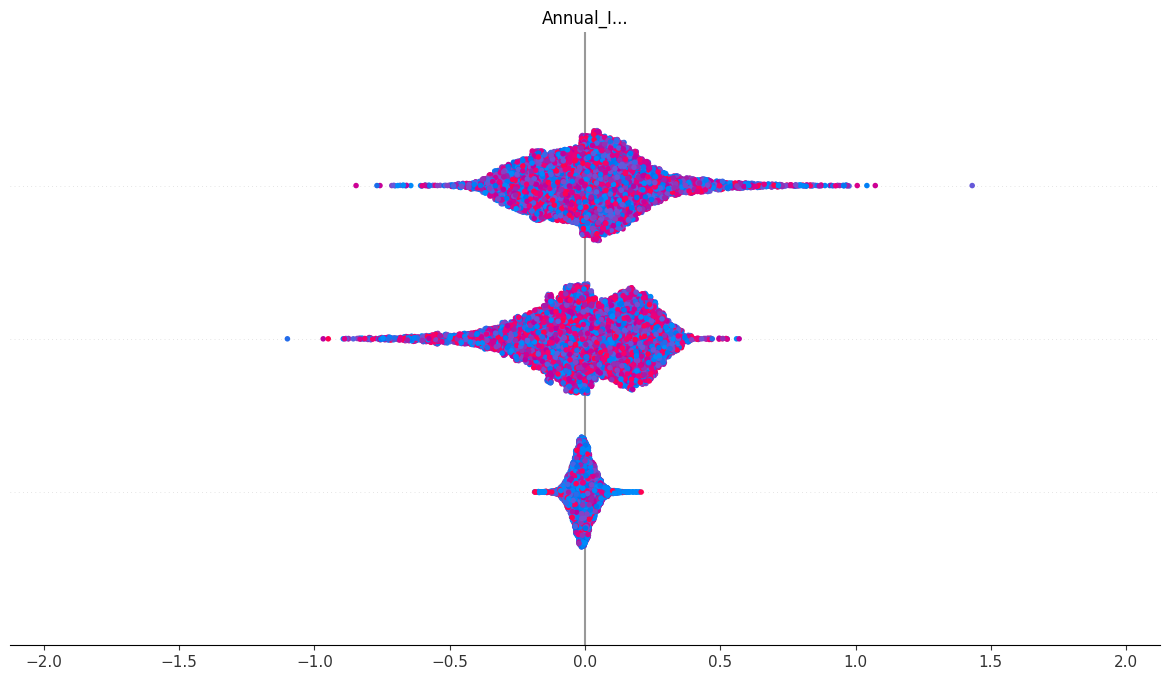

None


In [16]:
explainer = shap.TreeExplainer(clf_for_catboost)
shap_values = explainer.shap_values(X_test)

print(shap.summary_plot(shap_values, X_test))

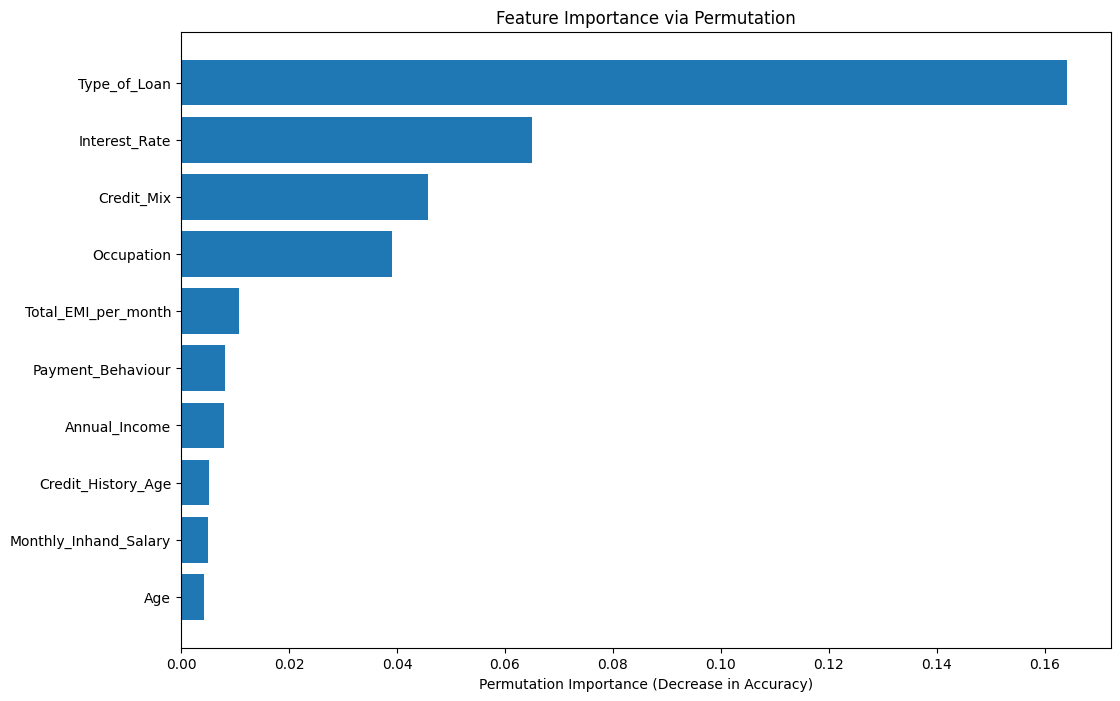

In [17]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(
    clf_for_catboost, 
    X_test, 
    y_test,
    n_repeats=30,  # Количество перестановок
    random_state=42,
    scoring='accuracy'  # Метрика для многоклассовой классификации
)

# Сортируем признаки по важности
sorted_idx = result.importances_mean.argsort()[::-1]
features = X.columns

# Визуализация
plt.figure(figsize=(12, 8))
plt.barh(features[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance (Decrease in Accuracy)")
plt.title("Feature Importance via Permutation")
plt.gca().invert_yaxis()  # Самые важные признаки сверху
plt.show()

In [18]:
with open('./saved_model/model.pkl', 'wb') as file:
    pickle.dump(clf_for_catboost, file)